# Worksheet: Miniproject 1
In this worksheet the Mandelbrot set is calculated in the region $C=\{a+ib\ : \ a\in[-2,\ 1]\ b\in[-1.5,\ 1.5]\}$ of the complex plane. Throughout this worksheet $N$ denotes the number of "pixles" the region is split into. This means that $C$ will be represented by an $N\times N$ matrix. <br>
An iteration is carried out for each entry in $C$, where the number of iterations are counted and plotted as an intensity plot. The number 2 is used as an upper bound for when a point diverges, since the sequency defining the Mandelbrot set diverges for $|z|>2$.<br>
In these implentations $N=2500$ and the maximum number of iterations over each point is 20.

## Setup
Here the necesarry modules are imported, along with each of the implementations (*naive*, *vectorized*, *numbad*, and *multicore* in the code cell below). A function used for plotting the Mandelbrot set is also defined.

In [1]:
import naive
import vectorized
import numbad
import multicore

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def plot_it(iterations, title):
    colormap = plt.cm.hot
    plt.imshow(iterations, cmap=colormap)
    plt.ylabel(r"$\Im$")
    plt.xlabel(r"$\Re$")
    plt.title(title)
    plt.show()


N = 2500
max_iter = 20

## Method overview
This section describes how each implementation works.

### The Naive Approach
The naive approach to implementing the algorithm in a nested for loop, where each entry in $C$ is iterated over one-by-one, to see if it converges or diverges

### The vectorized approach
The vectorized implementation utilizes the *numpy* library to spped up calculations. *Numpy* utilizes pipelining which results in more calculations per CPU clock, which speeds up calculations considereably. The *numpy* library also uses compiled *C*, *C++*, and *Fortran* code, which results in much less overhead than *Python* (which is an interpreted language) which also speeds up calculations. Numpy arrays are also stored contiguously in memory, which makes variable acces much faster.

### The Numba Approach
One of the reasons *Python* is slower than a language like *C* is that *Python* is an intepreted language, whereas *C* is compiled. This makes for more overhead, and an overall slower implementation of algorithms. Some languages like *Lua* utilize what is called just-in-time compilation, which results in it being much faster. The *numba* library in *python* allows us to implement just-in-time compilation in *python* code. This is done by adding a decorator above the function which we want to compile at runtime. There must be taken some precautions however, since *numba* doesn't "play well" with all native *python* code.
 As an axample: the function
```
numpy.linspace
```
which returns an array of equally spaced point in a given interval, doesn't work "out-of-the-box" with *numba*. To remedy this the entries in $C$ have an added method to them in the script *numbad.py*. More precisely; the line
 ```
 Rs = np.linspace(-2, 1, N).reshape((1, N))
 ```
 has been replaced with
 ```
 Rs = np.linspace(-2, 1, N).astype(np.float32)
 ```
 such that *numba* can compile it. This, and other quirks of implementing *numba* have all been taken care of in the script. <br>
 Note that the code still resembles that of the naive approach. This is because it is much easier to implement *numba* that way, and as will be seen later, this still runs faster than the vectorized approacch.

### The Multicore Processing Approach
This implementation utilizes the fact that modern CPUs consist of more than one core. Each core can carry out calculations independently from the others. This means that for embarrasingly parallelalizable algortihms, such as the Mandelbrot algorithm, the execution time can almost divided by the number of cores carrying out operations. This division is however, assymptotic. This is because the CPU must still spend time allocating computations to the different cores which, among other factors, contributes to some overhead. As will be seen later in this worksheet, this means that splitting a problem into too many sub-processes can actually increase the computation time, compared to if the algorithm was carried out on a single core. <br>
This method of multicore processing does also present some issues in the implementation. Among these is the fact that the *multiprocessing* library in pytho does not always recognize imported modules in the main script (This is because of the way the allocation of memory is done. The maintainers of the library state that the pickling occuring in the module results in functions declared in the main scope of the code not always recognizing imported modules in the same scope). In order to fix this issue I created a seperate module, containing the Mandelbrot algorithm to be carried out on some sub-matrix of $C$, which is then imported into the main module, along with any other necessary libraries. If the code does not run on your machine, the issue may lie with the *os* or *sys* package, which are used to import the python script *sub_mandelbrot.py*.

## Optimization of the Multicore Processing Approach
In order to determine the optimal number of sub-processes to split the problem into, the script *multicore.py* is run with a different number of processes specified each time. In this way we can find out which process count to use when comparing the different implementations with each other.<br>
The number of processes used are all divisors of $N$, to make the code implementation simpler. A plot can be seen below the code block, which displays the computing time as a function of the number of processes the problem is split into. From this plot we see that the optimal number of processes at this given $N$ and number of maximum iterations is 10 processes.

Optimal number of processes:  10


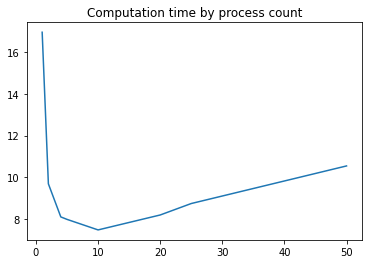

In [3]:
process_count = [1, 2, 4, 5, 10, 20, 25, 50]
times = []

for p in process_count:
    t0 = time.time()
    multicore.mandelbrot(N, p, max_iter)
    t1 = time.time() - t0
    times.append(t1)

plt.plot(process_count, times)
plt.title("Computation time by process count")
print("Optimal number of processes: ", process_count[np.argmin(times)])

## Comparison Between the Implementations
This section shows how the different implementations compare for a given $N$ and number of max iterations. To test this each implementation is carried out a number of times (specified by `runs`), and the average computation time is calculated using the `time.time()`function. The code block outputs a comparison betwee nthe implementations

In [ ]:
runs = 4
processes = 10
mean_time_names = ["Naive implementation",
                   "Vectorized implementation",
                   "Numba implementation",
                   "Multicore implementation1"]
mean_times = np.zeros(4)

for i in range(runs):
    t0 = time.time()
    naive_mandelbrot = naive.mandelbrot(N, max_iter=max_iter)
    tna = time.time() - t0

    t0 = time.time()
    vec_mandelbrot = vectorized.mandelbrot(N, max_iter=max_iter)
    tv = time.time() - t0

    t0 = time.time()
    numba_mandelbrot = numbad.mandelbrot(N, max_iter=max_iter)
    tnu = time.time() - t0

    t0 = time.time()
    multi_mandelbrot1 = multicore.mandelbrot(N, processes, max_iter=max_iter)
    tm1 = time.time() - t0

    mean_times[0] += tna/runs
    mean_times[1] += tv/runs
    mean_times[2] += tnu/runs
    mean_times[3] += tm1/runs

for i in range(4):
    print(mean_time_names[i] + ":", mean_times[i])

## Other optimizations
There are several different ways to further optimize this algorithm, an inexhaustive list is presented here:
- Using the *numxpr* library, which significantly speeds op calculations
- Utilizing the symmetry of the Mandelbrot set. It can be shown that a given points behave exactly like its complex conjugate when calculating the Mandelbrot set. This means that we can halve the computation time by only computing the upper half of the complex plane, if we don't take overhead into account.
- Since the multicore processing implementation uses *numpy* we could use `numpy.array_equal` to check if a region hasn't changed over an iteration. This means that we could quickly discard the outer corners of the set, since these regions diverge quickly.